In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import glob
from segment_anything import sam_model_registry, SamPredictor

def show_anns(anns,color_map:dict):
    if len(anns) == 0:
        return

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for i,ann in enumerate(anns):
        m = ann['segmentation']
        color_mask = color_map[str(i)]
        img[m] = color_mask

    return img

def click_handler(cord,masks):
    hist = []
    counter = 0
    for i, mask in enumerate(masks):
        if mask['segmentation'][cord[0][1]][cord[0][0]]:
            # print(i)
            src_clr = color_map[str(i)]
            # break
        
    for i,mask in enumerate(masks):
        if mask['segmentation'][cord[1][1]][cord[1][0]]:
            counter+=1
            hist.append(i)
            # print(i)
    if len(hist)<2:
        try:
            print(hist)
            color_map[str(hist[0])] = src_clr
        except Exception as e:
            print(e, '(Please Click on Segmented Region.)') 
    else:
        indx = find_smallest(hist,masks,cord[1])
        color_map[str(indx)] = src_clr
        
    return color_map

def find_smallest(hist,masks,cord):
    for indx in reversed(hist):
        if masks[indx]['segmentation'][cord[1]][cord[0]]:
            return indx

def click_event(event, x, y, flags, param):
    global coords
    global final
    if event == cv2.EVENT_LBUTTONDOWN:  # double left click event
        coords.append((x, y))
        if len(coords) == 2:
            print(coords)
            color_map = click_handler(coords, masks)
            masked_img = show_anns(masks,color_map)
            image_test = image_original / 255
            overlay = image_test * 0.4 + masked_img[:, :, 0:3]*0.6
            final = overlay
            # cv2.line(overlay, coords[0], coords[1], (0, 255, 0), 2)
            cv2.imshow('image', overlay)
            coords = []

label_map = {
'0':[0, 0, 1, 0.35],
'1':[0, 1, 0, 0.35],
'2':[1, 0, 0, 0.35]
}
def show_mask(mask, ax=None, classes=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        
    elif classes is not None and random_color is False:
        color = label_map[str(classes)]
        color = np.array(color)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    # img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    # img[:,:,3] = 0
    # for i,ann in enumerate(anns):
    #     m = ann['segmentation']
    #     color_mask = label_map[str(i)]
    #     img[m] = color_mask

    # return mask_image
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [11]:
files = glob.glob("yolov8_data/gnd_truths/*")
for file in files:
    print(file)
    with open(file,'r') as f:
        lines = f.readlines()
    labels = []
    bboxes = []
    # print(lines)
    for line in lines:
        line = line.strip('\n').split(' ')
        line = [float(i) for i in line]
        labels.append(int(line[0]))
        bboxes.append(line[1:])
    
    #lets read the image
    
    ref = file.split('/')[-1]
    input_test_image = 'yolov8_data/images/'+ref.replace('_gt.txt','.jpg')
    image_detect = cv2.imread(input_test_image) 
    image_detect = cv2.resize(image_detect, (1280, 720))
    image_detect = cv2.cvtColor(image_detect, cv2.COLOR_BGR2RGB)

    #lets load the weights for the dam model
    sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    predictor.set_image(image_detect)
    input_boxes = torch.tensor(bboxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image_detect.shape[:2])
    masks_det, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    print('     Seg Done.')
    size = masks_det[0][0].numpy().shape
    mask=np.zeros(size, dtype=np.int8)
    all_masks = np.squeeze(masks_det.numpy().astype(int),axis = 1)
    for i ,each_mask in enumerate(all_masks):
            mask += each_mask * (labels[i]+1)
    # mask[mask == 1] = 4
    # # Replace twos with ones
    # mask[mask == 2] = 1
    # # Replace threes (originally ones) with twos
    # mask[mask == 3] = 2
    # # Replace temporary value 4 with threes
    # mask[mask == 4] = 3
    cv2.imshow('image', mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    break
    pred_file = ref.split('_')[0]
    cv2.imwrite(f"seg_data/only_seg/pred/{pred_file}_pred.png",mask)
    binary_mask = np.zeros(size, dtype=np.uint8)
    img_height , img_width = size
    # Iterate over each bounding box and class label
    for bounding_box, class_label in zip(bboxes, labels):
        x = int(bounding_box[0]* img_width)
        y = int(bounding_box[1] * img_height)
        width =  int(bounding_box[2] * img_width)
        height = int(bounding_box[3] * img_height)

        # Create a binary mask for the current bounding box
        class_mask = np.zeros(size, dtype=np.uint8)
        class_mask[y:y+height, x:x+width] = class_label+1

        # Add the class mask to the binary mask
        binary_mask += class_mask 

    gnd_file = ref.split('_')[0]
    cv2.imwrite(f"seg_data/only_seg/gnd_truth/{gnd_file}_gt.png",binary_mask)
    print('     masks saved.')
        

yolov8_data/gnd_truths/11_gt.txt
     Seg Done.


error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/precomp.hpp:155: error: (-215:Assertion failed) src_depth != CV_16F && src_depth != CV_32S in function 'convertToShow'


: 

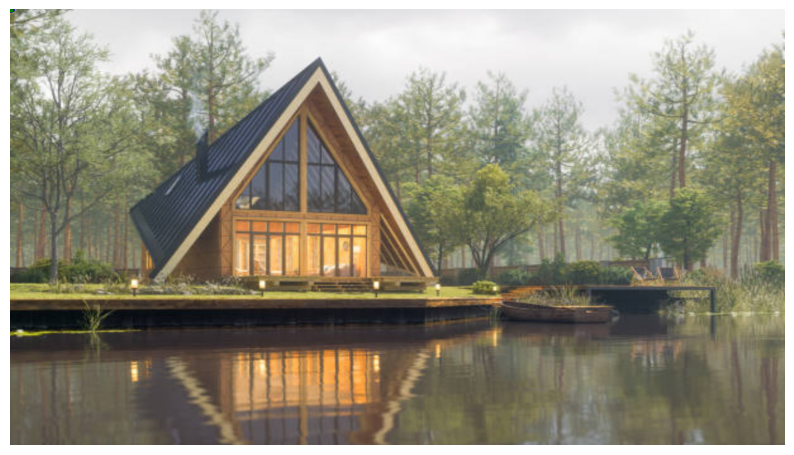

In [3]:

input_test_image = "yolov8_data/images/11.jpg"
image_detect = cv2.imread(input_test_image) 
image_detect = cv2.resize(image_detect, (1280, 720))
image_detect = cv2.cvtColor(image_detect, cv2.COLOR_BGR2RGB)
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image_detect)
input_boxes = torch.tensor(bboxes, device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image_detect.shape[:2])
masks_det, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
# Plotting Segmented Classes
cls = labels
# plt.figure(figsize=(10, 10))
# plt.imshow(image_detect)
for i ,mask in enumerate(masks_det):
    show_mask(mask=mask.cpu().numpy(), ax=plt.gca(), classes=cls[i], random_color=False)


In [5]:
size = masks_det[0][0].numpy().shape
mask=np.zeros(size, dtype=np.int32)
all_masks = np.squeeze(masks_det.numpy().astype(int),axis = 1)
for i ,each_mask in enumerate(all_masks):
        mask += each_mask * (cls[i]+1)
mask[mask == 1] = 4
# Replace twos with ones
mask[mask == 2] = 1
# Replace threes (originally ones) with twos
mask[mask == 3] = 2
# Replace temporary value 4 with threes
mask[mask == 4] = 3
cv2.imwrite("test.png",mask)

4

In [12]:
# Determine image dimensions
image_width = 640  # Replace with your image width
image_height = 480  # Replace with your image height

# Initialize the binary mask
binary_mask = np.zeros((image_height, image_width), dtype=np.uint8)

# Iterate over each bounding box and class label
for bounding_box, class_label in zip(bounding_boxes, class_labels):
    x, y, width, height = bounding_box

    # Create a binary mask for the current bounding box
    class_mask = np.zeros((image_height, image_width), dtype=np.uint8)
    class_mask[y:y+height, x:x+width] = 1

    # Add the class mask to the binary mask
    binary_mask += class_mask

[0, 0, 0, 0]

Image Loaded
Inferenece Done...



0: 384x640 1 window, 25.4ms
Speed: 2.0ms preprocess, 25.4ms inference, 15.9ms postprocess per image at shape (1, 3, 640, 640)


window 0 [372.5064697265625, 346.04864501953125, 593.427978515625, 441.43280029296875]


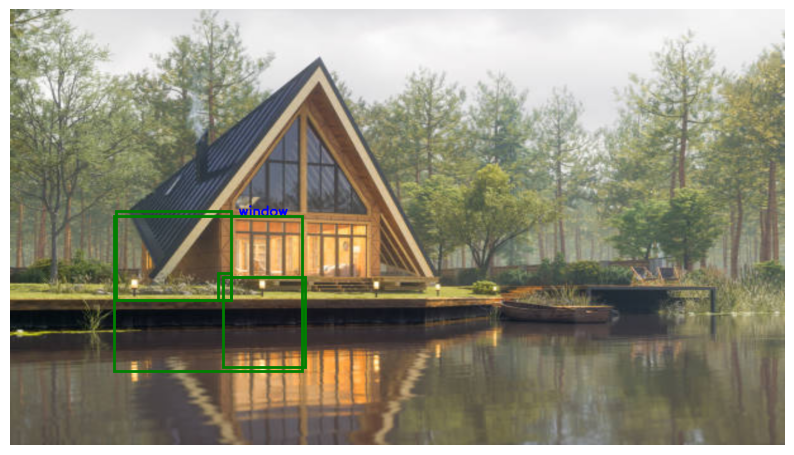

In [2]:
input_test_image = 'seg_data/only_seg/images/11.jpg' # <-- Input Image Path Here
image_original = cv2.imread(input_test_image) 
image_original = cv2.resize(image_original, (1280, 720))
image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
print("Image Loaded")
# Input the path of the SAM model checkpoint for inferencing, if relative path to directory not working....
# ....provide full path
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"  
model_type = "vit_h" 
device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_original)
print('Inferenece Done...')


image_detect = cv2.imread(input_test_image) 
image_detect = cv2.resize(image_detect, (1280, 720))
image_detect = cv2.cvtColor(image_detect, cv2.COLOR_BGR2RGB)
model = YOLO('weights/detetor/best_house.pt')
# If you want to save detector output, change 'save=True' In below code.
objects = model(image_detect, save=False, line_thickness=1, 
                stream=False, show_conf=False, show_labels=False, conf=0.40) 

for o in objects:
    if o is None:
        print('No Detections Found...')
        break
    boxes = o.boxes # Boxes object for bbox output
    cls = boxes.cls.type(torch.int)
    for i, (c, bbox) in enumerate(zip(cls, boxes.xyxy.tolist())):
        class_names = ['window', 'door', 'garage']
        output_index = c
        class_name = class_names[output_index]

        if len(cls) > 0 and  cls[i] == c:
            print(class_name, c.item(), bbox)

            x1, y1, x2, y2 = bbox
            # cv2.rectangle(image_detect, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
            text = class_name
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.75
            thickness = 2
            text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
            text_x = int(x1+5)
            text_y = int(y1-5)
            cv2.putText(image_detect, text, (text_x, text_y), font, font_scale, (0,0,255), thickness)

    #Implementing SAM 
    from segment_anything import sam_model_registry, SamPredictor

    sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    predictor.set_image(image_detect)
    bbox = [[482, 597, 172, 341], [365, 480, 175, 333], [365, 480, 343, 436], [487, 591, 351, 442]]
    input_boxes = torch.tensor(bbox, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image_detect.shape[:2])
    masks_det, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    # Plotting Segmented Classes
    cls =list(boxes.cls.cpu().numpy().astype(np.int32))
    cls = [0,0,0,0]
    plt.figure(figsize=(10, 10))
    plt.imshow(image_detect)
    cls = [0,0,0,0]
    for i ,mask in enumerate(masks_det):
        show_mask(mask=mask.cpu().numpy(), ax=plt.gca(), classes=cls[i], random_color=False)
# If you want to view the bounding boxes around the segmented area, remove Hastag at the start of below code.
    for box in input_boxes:        
        show_box(box.cpu().numpy(), plt.gca())  
    plt.axis('off')
    plt.savefig('sam_output/3.png')  # <-- If you want to save the below output, remove the Hashtag at the start. 
    plt.show()

In [12]:
input_boxes

tensor([[482, 597, 172, 341],
        [365, 480, 175, 333],
        [365, 480, 343, 436],
        [487, 591, 351, 442]])

In [7]:
objects[0].boxes.xyxy

tensor([[372.5065, 346.0486, 593.4280, 441.4328]], device='cuda:0')

In [8]:
bbox

[[482, 597, 172, 341],
 [365, 480, 175, 333],
 [365, 480, 343, 436],
 [487, 591, 351, 442]]

In [9]:
len(masks_det)

4

In [10]:
size = masks_det[0][0].numpy().shape
mask=np.zeros(size, dtype=np.int32)
all_masks = np.squeeze(masks_det.numpy().astype(int),axis = 1)
for i ,each_mask in enumerate(all_masks):
        mask += each_mask * (cls[i]+1)
# cv2.imwrite("test.png",mask)

True

In [14]:
cls

[0, 0, 0, 0]

In [1]:
file = "yolov8_data/resized/anns/11_gt.txt"
with open(file,'r') as f:
        lines = f.readlines()
labels = []
bboxes = []
# print(lines)
for line in lines:
    line = line.strip('\n').split(' ')
    line = [float(i) for i in line]
    labels.append(int(line[0]))
    bboxes.append(line[1:])



In [45]:
bboxes

[[0.2140625, 0.3506944444444444, 0.078515625, 0.1125],
 [0.382421875, 0.3458333333333333, 0.081640625, 0.12777777777777777],
 [0.55390625, 0.34930555555555554, 0.071875, 0.10555555555555556],
 [0.78828125, 0.36041666666666666, 0.103125, 0.08333333333333333],
 [0.55546875, 0.5958333333333333, 0.1109375, 0.14722222222222223],
 [0.19609375, 0.5993055555555555, 0.098046875, 0.15416666666666667],
 [0.548828125, 0.1638888888888889, 0.0328125, 0.09791666666666667],
 [0.384765625, 0.6277777777777778, 0.08671875, 0.1763888888888889],
 [0.8203125, 0.7048611111111112, 0.241796875, 0.1638888888888889]]

In [4]:
import cv2
import numpy as np

img = cv2.imread('seg_data/only_seg/images/11.jpg')
size = (720,1280)
binary_mask = np.zeros(size, dtype=np.uint8)
img_height , img_width, _ = img.shape
bbox=[]
# Iterate over each bounding box and class label
for bounding_box, class_label in zip(bboxes, labels):
        x = int(bounding_box[0]* img_width)
        y = int(bounding_box[1] * img_height)
        width =  int(bounding_box[2] * img_width)
        height = int(bounding_box[3] * img_height)
        x1,y1,x2,y2 = int(x-(width/2)), int(y-(height/2)), int(x+(width/2)), int(y+(height/2))
        img = cv2.rectangle(img, (x1,y1), (x2,y2), (255, 0, 0), 2) 
        bbox.append([x1,y1,x2,y2])
        # Create a binary mask for the current bounding box
        class_mask = np.zeros(size, dtype=np.uint8)
        class_mask[y1:y2, x1:x2] = class_label+1

        # Add the class mask to the binary mask
        binary_mask += class_mask 

In [5]:
bbox

[[171, 490, 334, 520],
 [731, 468, 930, 541],
 [706, 591, 1094, 672],
 [484, 566, 583, 640]]

In [6]:
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to target thread (0x555e9035edd0)

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to target thread (0x555e9035edd0)

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to target thread (0x555e9035edd0)

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to target thread (0x555e9035edd0)

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to target thread (0x555e9035edd0)

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to target thread (0x555e9035edd0)

QObject::moveToThread: Current thread (0x555e9035edd0) is not the object's thread (0x555e8ffa6d60).
Cannot move to tar

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import glob
from segment_anything import sam_model_registry, SamPredictor

def show_anns(anns,color_map:dict):
    if len(anns) == 0:
        return

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for i,ann in enumerate(anns):
        m = ann['segmentation']
        color_mask = color_map[str(i)]
        img[m] = color_mask

    return img

def click_handler(cord,masks):
    hist = []
    counter = 0
    for i, mask in enumerate(masks):
        if mask['segmentation'][cord[0][1]][cord[0][0]]:
            # print(i)
            src_clr = color_map[str(i)]
            # break
        
    for i,mask in enumerate(masks):
        if mask['segmentation'][cord[1][1]][cord[1][0]]:
            counter+=1
            hist.append(i)
            # print(i)
    if len(hist)<2:
        try:
            print(hist)
            color_map[str(hist[0])] = src_clr
        except Exception as e:
            print(e, '(Please Click on Segmented Region.)') 
    else:
        indx = find_smallest(hist,masks,cord[1])
        color_map[str(indx)] = src_clr
        
    return color_map

def find_smallest(hist,masks,cord):
    for indx in reversed(hist):
        if masks[indx]['segmentation'][cord[1]][cord[0]]:
            return indx

def click_event(event, x, y, flags, param):
    global coords
    global final
    if event == cv2.EVENT_LBUTTONDOWN:  # double left click event
        coords.append((x, y))
        if len(coords) == 2:
            print(coords)
            color_map = click_handler(coords, masks)
            masked_img = show_anns(masks,color_map)
            image_test = image_original / 255
            overlay = image_test * 0.4 + masked_img[:, :, 0:3]*0.6
            final = overlay
            # cv2.line(overlay, coords[0], coords[1], (0, 255, 0), 2)
            cv2.imshow('image', overlay)
            coords = []

label_map = {
'0':[0, 0, 1, 0.35],
'1':[0, 1, 0, 0.35],
'2':[1, 0, 0, 0.35]
}
def show_mask(mask, ax=None, classes=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        
    elif classes is not None and random_color is False:
        color = label_map[str(classes)]
        color = np.array(color)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
        
    h, w = mask.shape[-2:]
    mask_image = mimage
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))



895098

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os
import glob
from segment_anything import sam_model_registry, SamPredictor

def show_anns(anns,color_map:dict):
    if len(anns) == 0:
        return

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for i,ann in enumerate(anns):
        m = ann['segmentation']
        color_mask = color_map[str(i)]
        img[m] = color_mask

    return img

def click_handler(cord,masks):
    hist = []
    counter = 0
    for i, mask in enumerate(masks):
        if mask['segmentation'][cord[0][1]][cord[0][0]]:
            # print(i)
            src_clr = color_map[str(i)]
            # break
        
    for i,mask in enumerate(masks):
        if mask['segmentation'][cord[1][1]][cord[1][0]]:
            counter+=1
            hist.append(i)
            # print(i)
    if len(hist)<2:
        try:
            print(hist)
            color_map[str(hist[0])] = src_clr
        except Exception as e:
            print(e, '(Please Click on Segmented Region.)') 
    else:
        indx = find_smallest(hist,masks,cord[1])
        color_map[str(indx)] = src_clr
        
    return color_map

def find_smallest(hist,masks,cord):
    for indx in reversed(hist):
        if masks[indx]['segmentation'][cord[1]][cord[0]]:
            return indx

def click_event(event, x, y, flags, param):
    global coords
    global final
    if event == cv2.EVENT_LBUTTONDOWN:  # double left click event
        coords.append((x, y))
        if len(coords) == 2:
            print(coords)
            color_map = click_handler(coords, masks)
            masked_img = show_anns(masks,color_map)
            image_test = image_original / 255
            overlay = image_test * 0.4 + masked_img[:, :, 0:3]*0.6
            final = overlay
            # cv2.line(overlay, coords[0], coords[1], (0, 255, 0), 2)
            cv2.imshow('image', overlay)
            coords = []

label_map = {
'0':[0, 0, 1, 0.35],
'1':[0, 1, 0, 0.35],
'2':[1, 0, 0, 0.35]
}
def show_mask(mask, ax=None, classes=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        
    elif classes is not None and random_color is False:
        color = label_map[str(classes)]
        color = np.array(color)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
        
    h, w = mask.shape[-2:]
    mask_image = mimage
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [44]:
import glob
files = glob.glob("seg_data/only_seg/train/lbls/*")
files

['seg_data/only_seg/train/lbls/45_gt.txt',
 'seg_data/only_seg/train/lbls/42_gt.txt',
 'seg_data/only_seg/train/lbls/37_gt.txt',
 'seg_data/only_seg/train/lbls/36_gt.txt',
 'seg_data/only_seg/train/lbls/43_gt.txt',
 'seg_data/only_seg/train/lbls/40_gt.txt',
 'seg_data/only_seg/train/lbls/38_gt.txt',
 'seg_data/only_seg/train/lbls/39_gt.txt',
 'seg_data/only_seg/train/lbls/51_gt.txt',
 'seg_data/only_seg/train/lbls/46_gt.txt',
 'seg_data/only_seg/train/lbls/44_gt.txt',
 'seg_data/only_seg/train/lbls/41_gt.txt',
 'seg_data/only_seg/train/lbls/47_gt.txt',
 'seg_data/only_seg/train/lbls/49_gt.txt',
 'seg_data/only_seg/train/lbls/34_gt.txt',
 'seg_data/only_seg/train/lbls/35_gt.txt',
 'seg_data/only_seg/train/lbls/48_gt.txt',
 'seg_data/only_seg/train/lbls/50_gt.txt']

In [63]:
len(files)

18

In [64]:
height = 720
width = 1280
file = files[17]

with open(file,'r') as f:
    lines = f.readlines()
labels = []
bboxes = []
# print(lines)
for line in lines:
    line = line.strip('\n').split(' ')
    line = [float(i) for i in line]
    labels.append(int(line[0]))
    bboxes.append(line[1:])
bbox =[]
for box in bboxes:
    x,y,w,h = int(box[0]*width),int(box[1]*height),int(box[2]*width),int(box[3]*height)
    x1,y1,x2,y2 = x-(w/2),y-(h/2),x+(w/2),y+(h/2)
    # x1,y1,x2,y2 = x,y,x+(w/2),y+(h/2)
    box = [int(x1),int(y1),int(x2),int(y2)]
    bbox.append(box)

#lets read the image
ref = file.split('/')[-1]
input_test_image = 'seg_data/only_seg/train/imgs/'+ref.replace('_gt.txt','.jpg')
image = cv2.imread(input_test_image)
image = cv2.resize(image, (1280, 720))
for box in bbox:
    image = cv2.rectangle(image, (box[0],box[1]), (box[2],box[3]), (255, 0, 0), 2)
# cv2.imshow('check',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
image_detect = cv2.imread(input_test_image) 
image_detect = cv2.resize(image_detect, (1280, 720))
image_detect = cv2.cvtColor(image_detect, cv2.COLOR_BGR2RGB)

#lets load the weights for the dam model
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"  # Choose what to use for infrerence ('cpu', 'cuda'), CPU recommended if GPU not available

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image_detect)
input_boxes = torch.tensor(bbox, device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image_detect.shape[:2])
masks_det, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
print('     Seg Done.')
size = masks_det[0][0].numpy().shape
mask=np.zeros(size, dtype=np.int8)
all_masks = np.squeeze(masks_det.numpy().astype(int),axis = 1)
for i ,each_mask in enumerate(all_masks):
        mask += each_mask * (labels[i]+1)
        

pred_file = ref.split('_')[0]
cv2.imwrite(f"seg_data/only_seg/train/pred/{pred_file}_pred.png",mask)
binary_mask = np.zeros(size, dtype=np.uint8)
img_height , img_width = size
# Iterate over each bounding box and class label
for bounding_box, class_label in zip(bboxes, labels):
    x = int(bounding_box[0]* img_width)
    y = int(bounding_box[1] * img_height)
    width =  int(bounding_box[2] * img_width)
    height = int(bounding_box[3] * img_height)
    x1,y1,x2,y2 = int(x-(width/2)), int(y-(height/2)), int(x+(width/2)), int(y+(height/2))
    # img = cv2.rectangle(img, (x1,y1), (x2,y2), (255, 0, 0), 2) 

    # Create a binary mask for the current bounding box
    class_mask = np.zeros(size, dtype=np.uint8)
    class_mask[y1:y2, x1:x2] = class_label+1

    # Add the class mask to the binary mask
    binary_mask += class_mask 

gnd_file = ref.split('_')[0]
cv2.imwrite(f"seg_data/only_seg/train/gnd_truth/{gnd_file}_gt.png",binary_mask)

     Seg Done.


True

In [14]:
mask = cv2.imread('seg_data/only_seg/pred/0_pred.png',cv2.IMREAD_GRAYSCALE)

In [15]:
# Define the colors for each class
colors = {
    0: (0, 0, 0),        # Background (black)
    1: (255, 0, 0),      # Class 1 (red)
    2: (0, 255, 0),      # Class 2 (green)
    3: (0, 0, 255)       # Class 3 (blue)
}

# Load the binary mask image (single-channel image with class labels as pixel values)
# mask = cv2.imread('binary_mask.png', cv2.IMREAD_GRAYSCALE)

# Initialize an empty colored mask (3-channel image)
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

# Iterate over each class and assign the corresponding color to the colored mask
for class_label, color in colors.items():
    colored_mask[mask == class_label] = color

cv2.imwrite('colored_test.png',colored_mask)

True

In [50]:
cv2.imwrite('test.png',img)

True